# Multi-head Attention

![Screenshot 2025-09-08 at 19.35.41.png](<attachment:Screenshot 2025-09-08 at 19.35.41.png>)
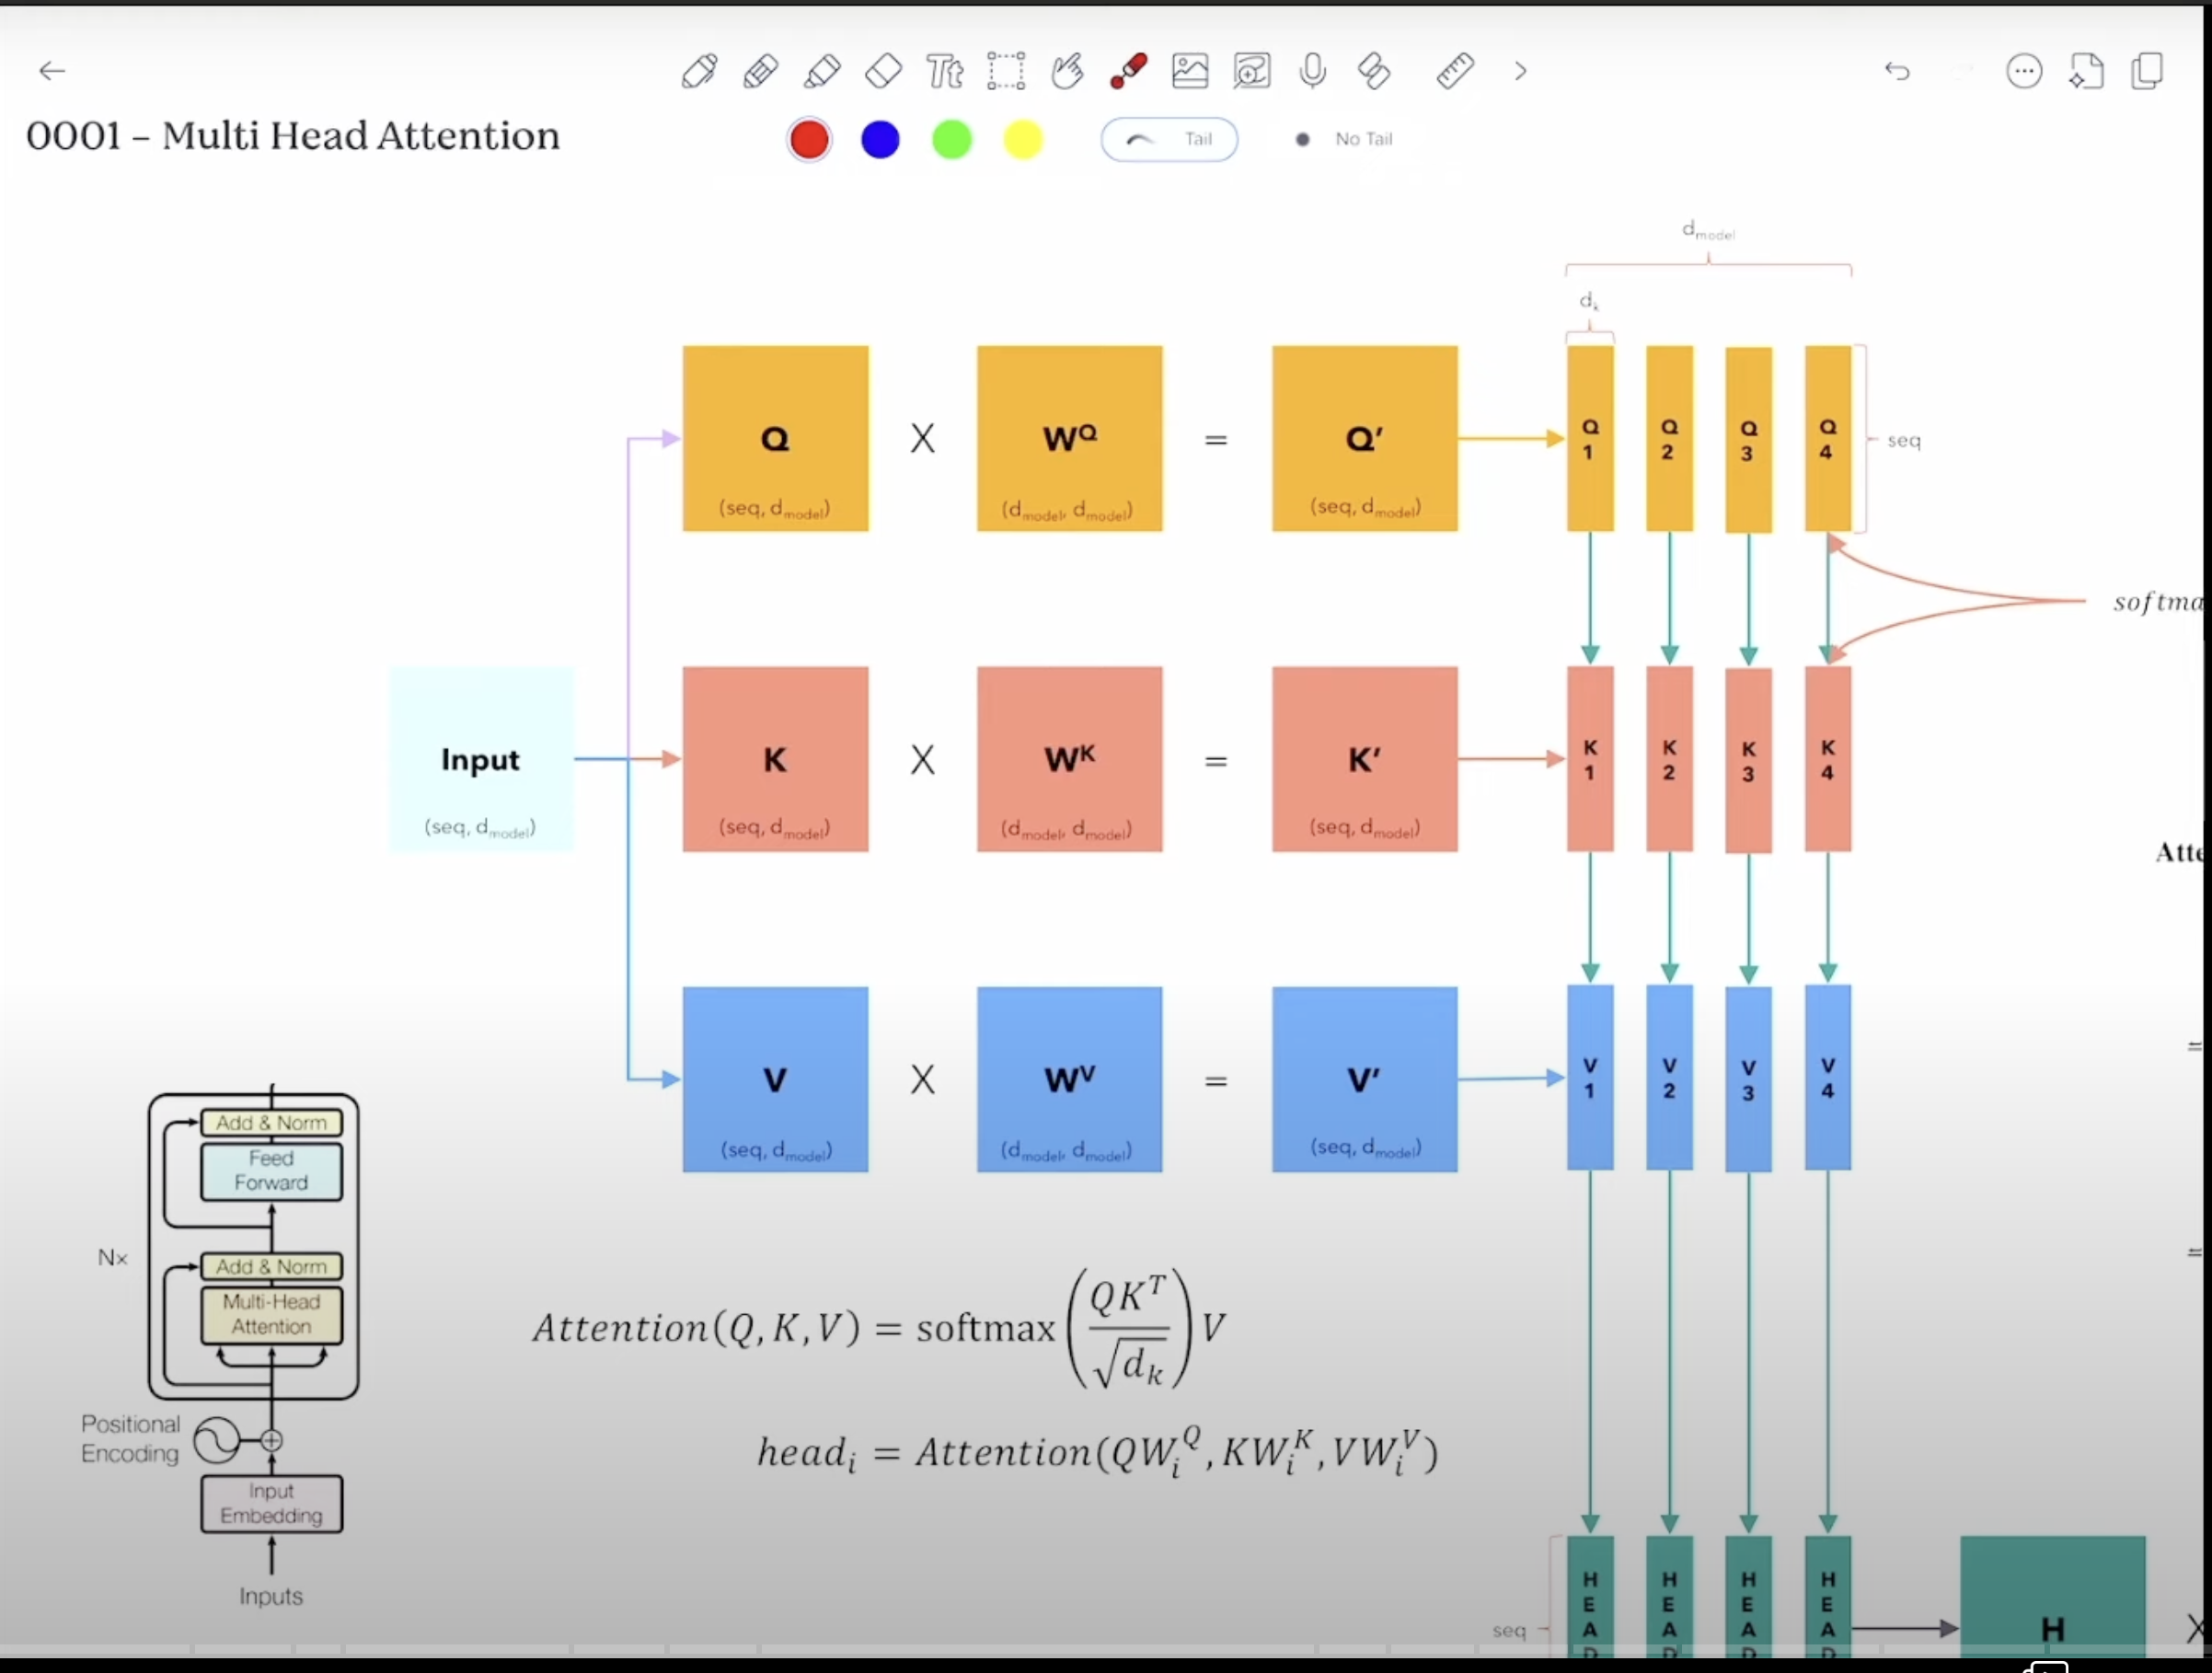

#### MHA starts with single input sequence or two input sequence  in regard to cross head attention

-------------------------------------------------------------------
When we talk about **multi-head attention**, we’re dealing with two main contexts:

1. **Self-Attention**

   * This starts with a **single input sequence** (for example, a sentence: *“The cat sat on the mat”*).
   * The same sequence is used to generate **queries (Q), keys (K), and values (V)**.
   * Each token (like *“cat”*) attends to all other tokens in that same sequence.
   * Example: in *“The cat sat”*, the word *“cat”* might pay more attention to *“sat”* than *“the”*.

2. **Cross-Attention**

   * This involves **two input sequences**.
   * Common in encoder-decoder architectures (like in Transformers for translation).
   * One sequence (say, from the encoder = source sentence in French) provides the **keys (K) and values (V)**.
   * The other sequence (say, from the decoder = English being generated) provides the **queries (Q)**.
   * This allows the decoder to “look at” the encoder’s sequence while generating output.

---

### So in short:

* **Self-attention (single sequence):** Q, K, V all come from the **same sequence**.
* **Cross-attention (two sequences):** Q comes from the **decoder sequence**, while K and V come from the **encoder sequence**.

And **multi-head** just means we do this in parallel with multiple sets of Q/K/V projections, so the model can capture different types of relationships (e.g., syntax, semantics, long-distance dependencies).


-------------------------------------------------------------------------

#### our input seq is (seq, d_model) : where seq is number of sequences/tokens and each seq is represeneted by an embedding vector with d_model  dimensions 

-------------------------------------------------------------------------

Exactly ✅ you’ve got the shape right. Let’s unpack this carefully with respect to **multi-head attention**.

---

### Input Representation

* You start with a batch of tokens (let’s ignore batch size for now).
* The input tensor is:

$$
X \in \mathbb{R}^{(\text{seq\_len}, d_\text{model})}
$$

where:

* **seq\_len** = number of tokens in the sequence
* **d\_model** = embedding dimension (e.g., 512 or 768 in Transformers)

So each token is a row vector of size $d_\text{model}$.

---

### In **Self-Attention**

We project the same input $X$ three different ways to get **Q, K, V**:

$$
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
$$

where $W_Q, W_K, W_V \in \mathbb{R}^{d_\text{model} \times d_k}$.

* So all queries, keys, and values are derived from the **same sequence**.
* Shapes:

  * $Q, K, V \in \mathbb{R}^{(\text{seq\_len}, d_k)}$

Then attention is computed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

---

### In **Cross-Attention**

We have **two sequences**:

* Decoder input (say, partially generated English translation): $X_{dec} \in \mathbb{R}^{(\text{seq\_len}^{dec}, d_\text{model})}$
* Encoder output (say, processed French sentence): $X_{enc} \in \mathbb{R}^{(\text{seq\_len}^{enc}, d_\text{model})}$

We then project them differently:

$$
Q = X_{dec}W_Q, \quad K = X_{enc}W_K, \quad V = X_{enc}W_V
$$

* Queries come from the **decoder sequence**.
* Keys & values come from the **encoder sequence**.
* Shapes:

  * $Q \in \mathbb{R}^{(\text{seq\_len}^{dec}, d_k)}$
  * $K, V \in \mathbb{R}^{(\text{seq\_len}^{enc}, d_k)}$

This way, the decoder tokens can attend to the entire encoder sequence.

---

### Multi-Head Part

Instead of doing this once, we split $d_\text{model}$ into multiple “heads”:

* Suppose $d_\text{model} = 512$, number of heads = 8.
* Then each head works with $d_k = d_v = 64$.
* We compute attention **in parallel** for each head and then concatenate results:

$$
\text{MultiHead}(Q,K,V) = \text{Concat}(head_1, \ldots, head_h)W_O
$$

---

👉 So your intuition was correct:

* **Shape starts as (seq\_len, d\_model)**.
* In **self-attention**, Q, K, V all come from the same input.
* In **cross-attention**, Q comes from one sequence (decoder), while K and V come from another (encoder).




#### W_q, W_k and W_v are all represented by linear layers  and these layers are (d_model, d_model), so they dont change the shape of input tensor 


![Screenshot 2025-09-08 at 22.58.55.png](<attachment:Screenshot 2025-09-08 at 22.58.55.png>)

in practice, **$W_Q$, $W_K$, $W_V$ are implemented as linear (dense) layers with weight matrices of shape**

$$
(d_\text{model}, d_\text{model})
$$

That means if your input tensor is

$$
X \in \mathbb{R}^{(\text{seq\_len}, d_\text{model})}
$$

then

$$
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
$$

all have **the same shape**:

$$
Q, K, V \in \mathbb{R}^{(\text{seq\_len}, d_\text{model})}
$$

---

### But where does $d_k$ and $d_v$ come in then?

That happens when we **split into heads**.

* Let’s say:

  * $d_\text{model} = 512$
  * Number of heads $h = 8$
  * Then each head works on subspaces of size:

  $$
  d_k = d_v = \frac{d_\text{model}}{h} = 64
  $$

* After computing $Q, K, V \in (\text{seq\_len}, d_\text{model})$,
  we **reshape** them into

  $$
  (\text{seq\_len}, h, d_k)
  $$

* Attention is computed **per head** on the $d_k$-dimensional slices.

---

### Workflow Recap

1. Input:

   $$
   X \in (\text{seq\_len}, d_\text{model})
   $$

2. Linear projections (no shape change):

   $$
   Q, K, V \in (\text{seq\_len}, d_\text{model})
   $$

3. Reshape/split into heads:

   $$
   Q, K, V \in (\text{seq\_len}, h, d_k), \quad d_k = d_\text{model}/h
   $$

4. Scaled dot-product attention per head:

   $$
   \text{Attention}_i(Q,K,V) \in (\text{seq\_len}, d_v), \quad d_v = d_k
   $$

5. Concatenate across heads:

   $$
   \text{Concat}(head_1,\dots,head_h) \in (\text{seq\_len}, d_\text{model})
   $$

6. Final linear projection $W_O \in (d_\text{model}, d_\text{model})$ to mix head outputs.

---

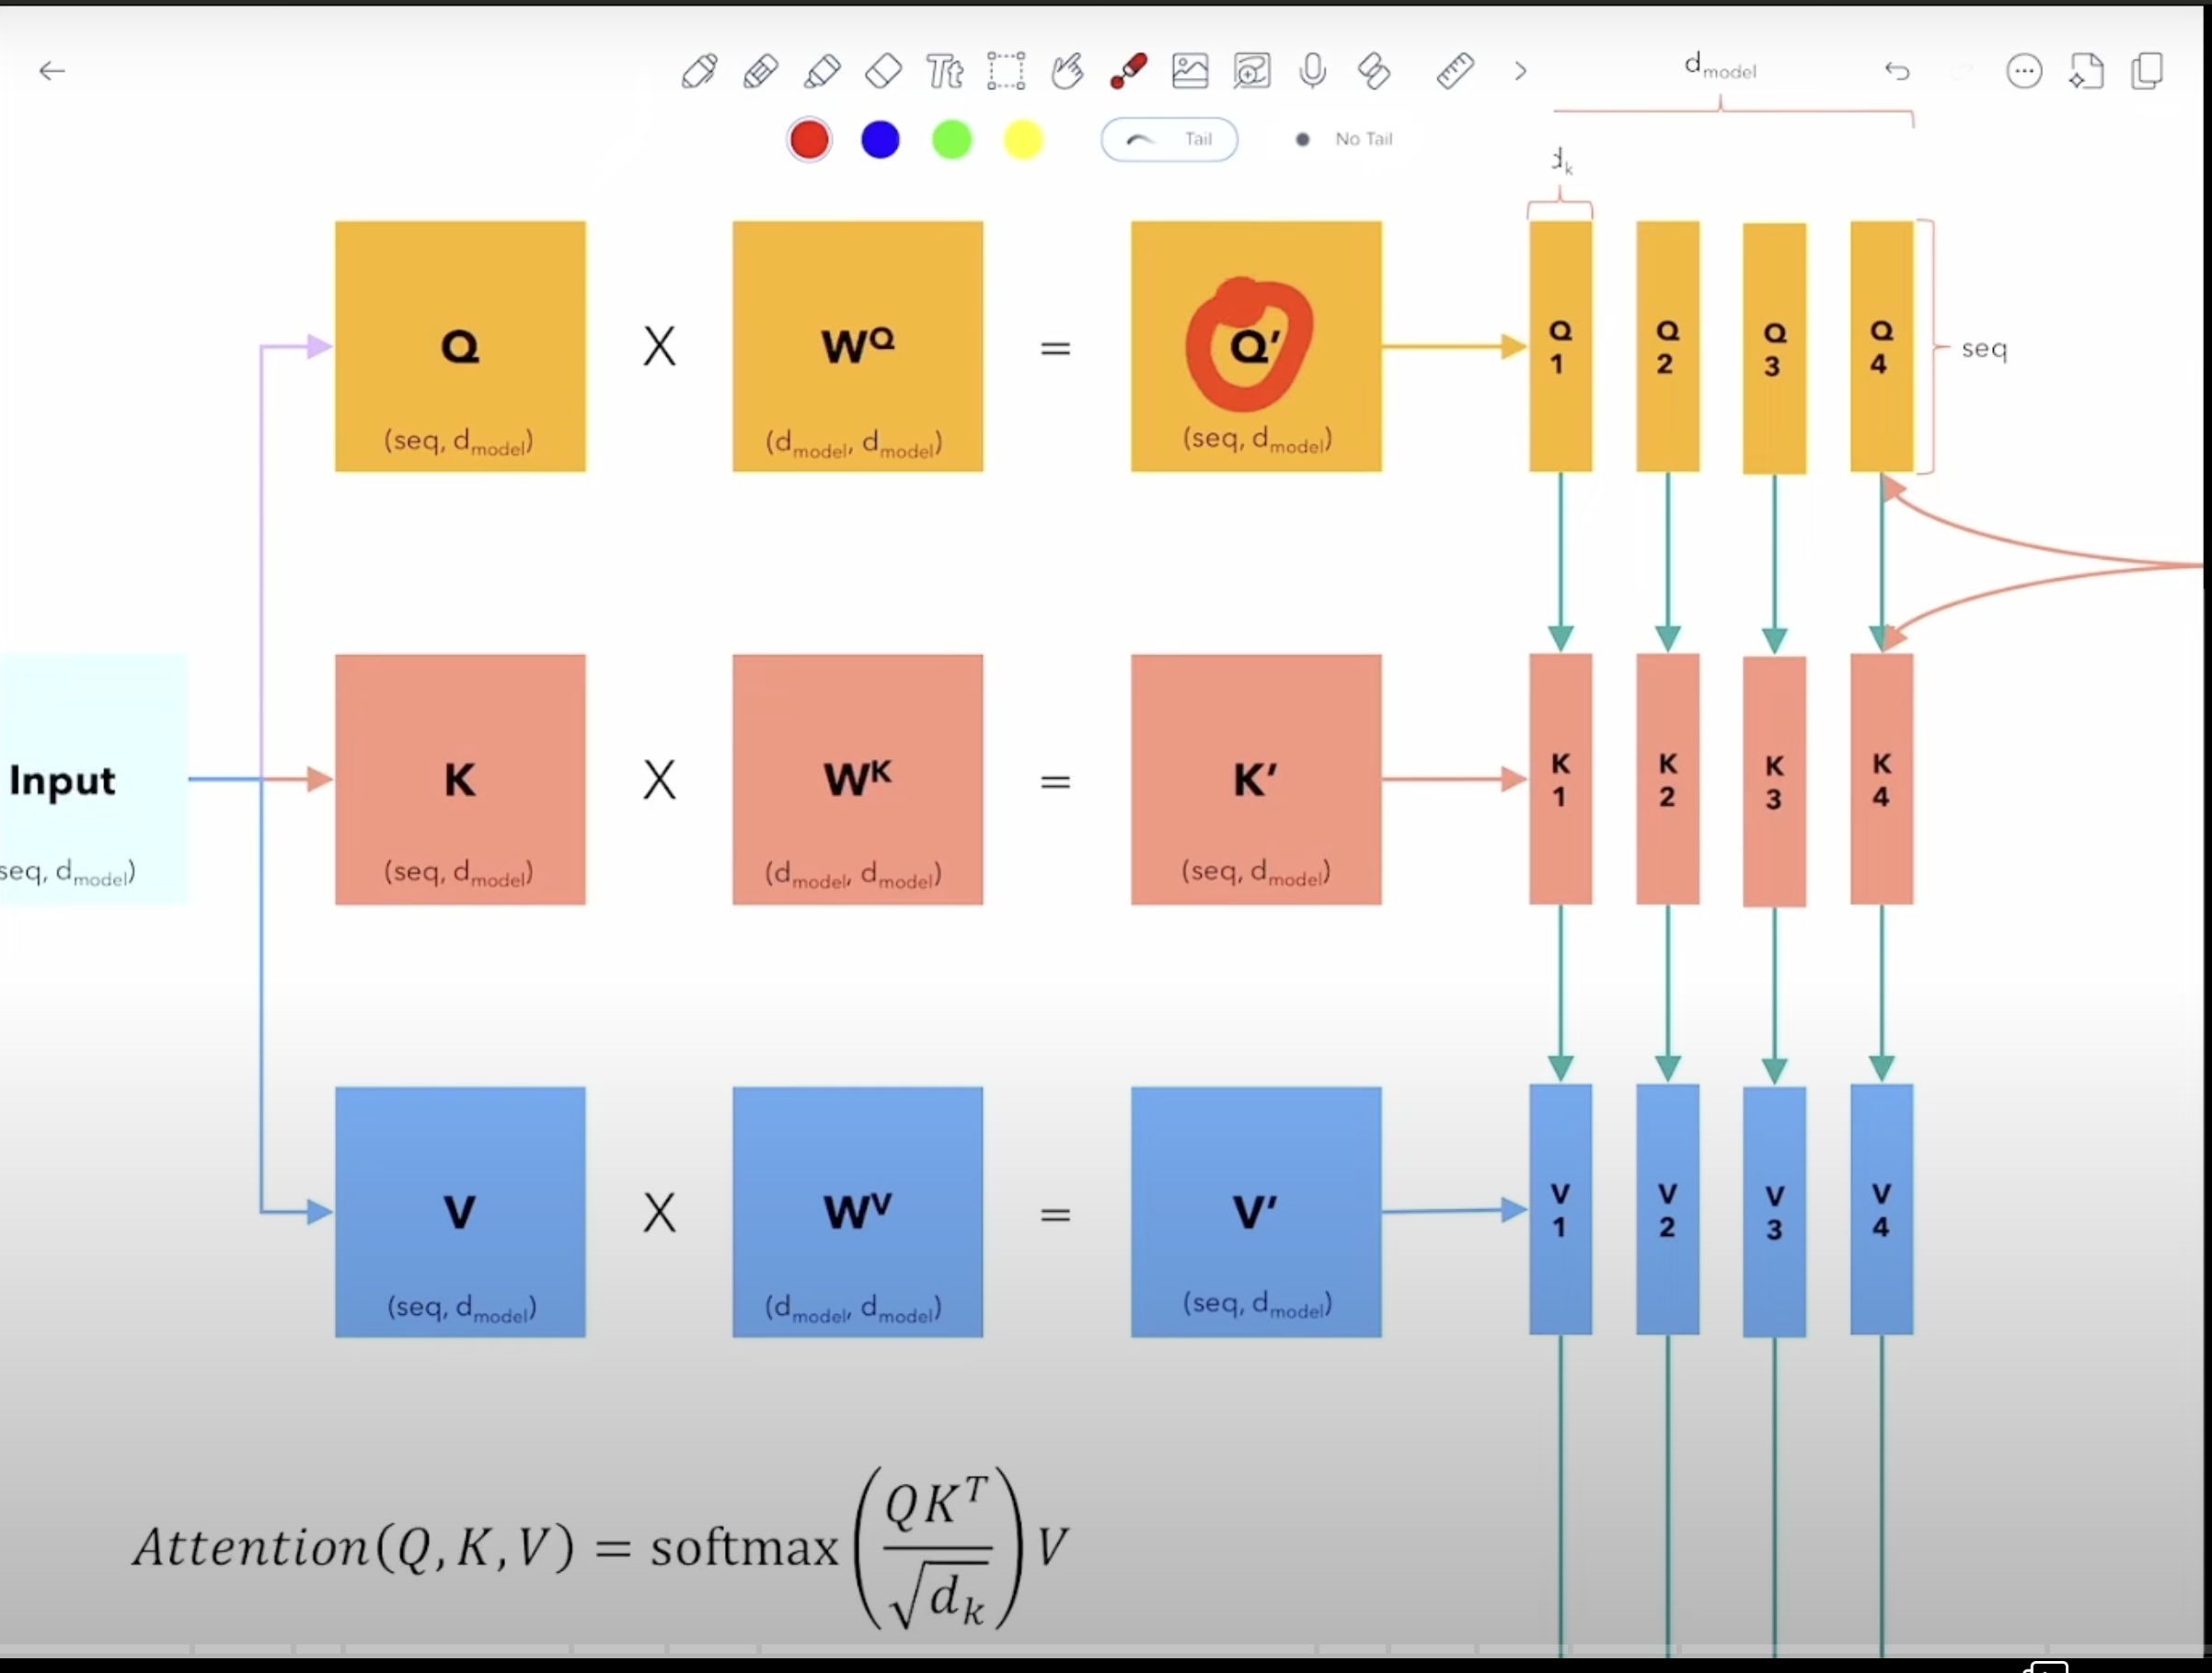

#### then we divide Q`, K` and V` in smaller embeddings 

![Screenshot 2025-09-08 at 23.03.27.png](<attachment:Screenshot 2025-09-08 at 23.03.27.png>)


----------------------------------------------------------------------------
### Step 1 — Start with projections

We project the input with $W_Q, W_K, W_V$, each of size $(d_\text{model}, d_\text{model})$:

$$
Q', K', V' \in \mathbb{R}^{(\text{seq\_len}, d_\text{model})}
$$

At this point, they still have the **same dimension** as the input.

---

### Step 2 — Split into heads

Now, let’s assume:

* $d_\text{model} = 512$
* Number of heads $h = 8$
* Then each head gets:

$$
d_k = d_v = \frac{d_\text{model}}{h} = 64
$$

We reshape:

$$
Q', K', V' \;\; \to \;\; ( \text{seq\_len}, h, d_k )
$$

So for each token, instead of one $512$-dim vector, you now have **8 parallel 64-dim sub-vectors** — one per head.

---

### Step 3 — Attention per head

For each head $i$:

$$
\text{Attention}_i(Q_i, K_i, V_i) = \text{softmax}\!\left(\frac{Q_i K_i^T}{\sqrt{d_k}}\right) V_i
$$

Output shape per head:

$$
(\text{seq\_len}, d_v)
$$

---

### Step 4 — Concatenate heads

We concatenate all head outputs back together:

$$
\text{Concat}(head_1, \dots, head_h) \in (\text{seq\_len}, d_\text{model})
$$

---

### Step 5 — Final linear layer

A last linear projection $W_O \in (d_\text{model}, d_\text{model})$ mixes the head information.

---

So when you say:

> “then we divide Q’, K’, V’ in smaller embeddings”

that is **precisely the reshaping into $(seq\_len, h, d_k)$**, where each smaller embedding is what each attention head works on.

---

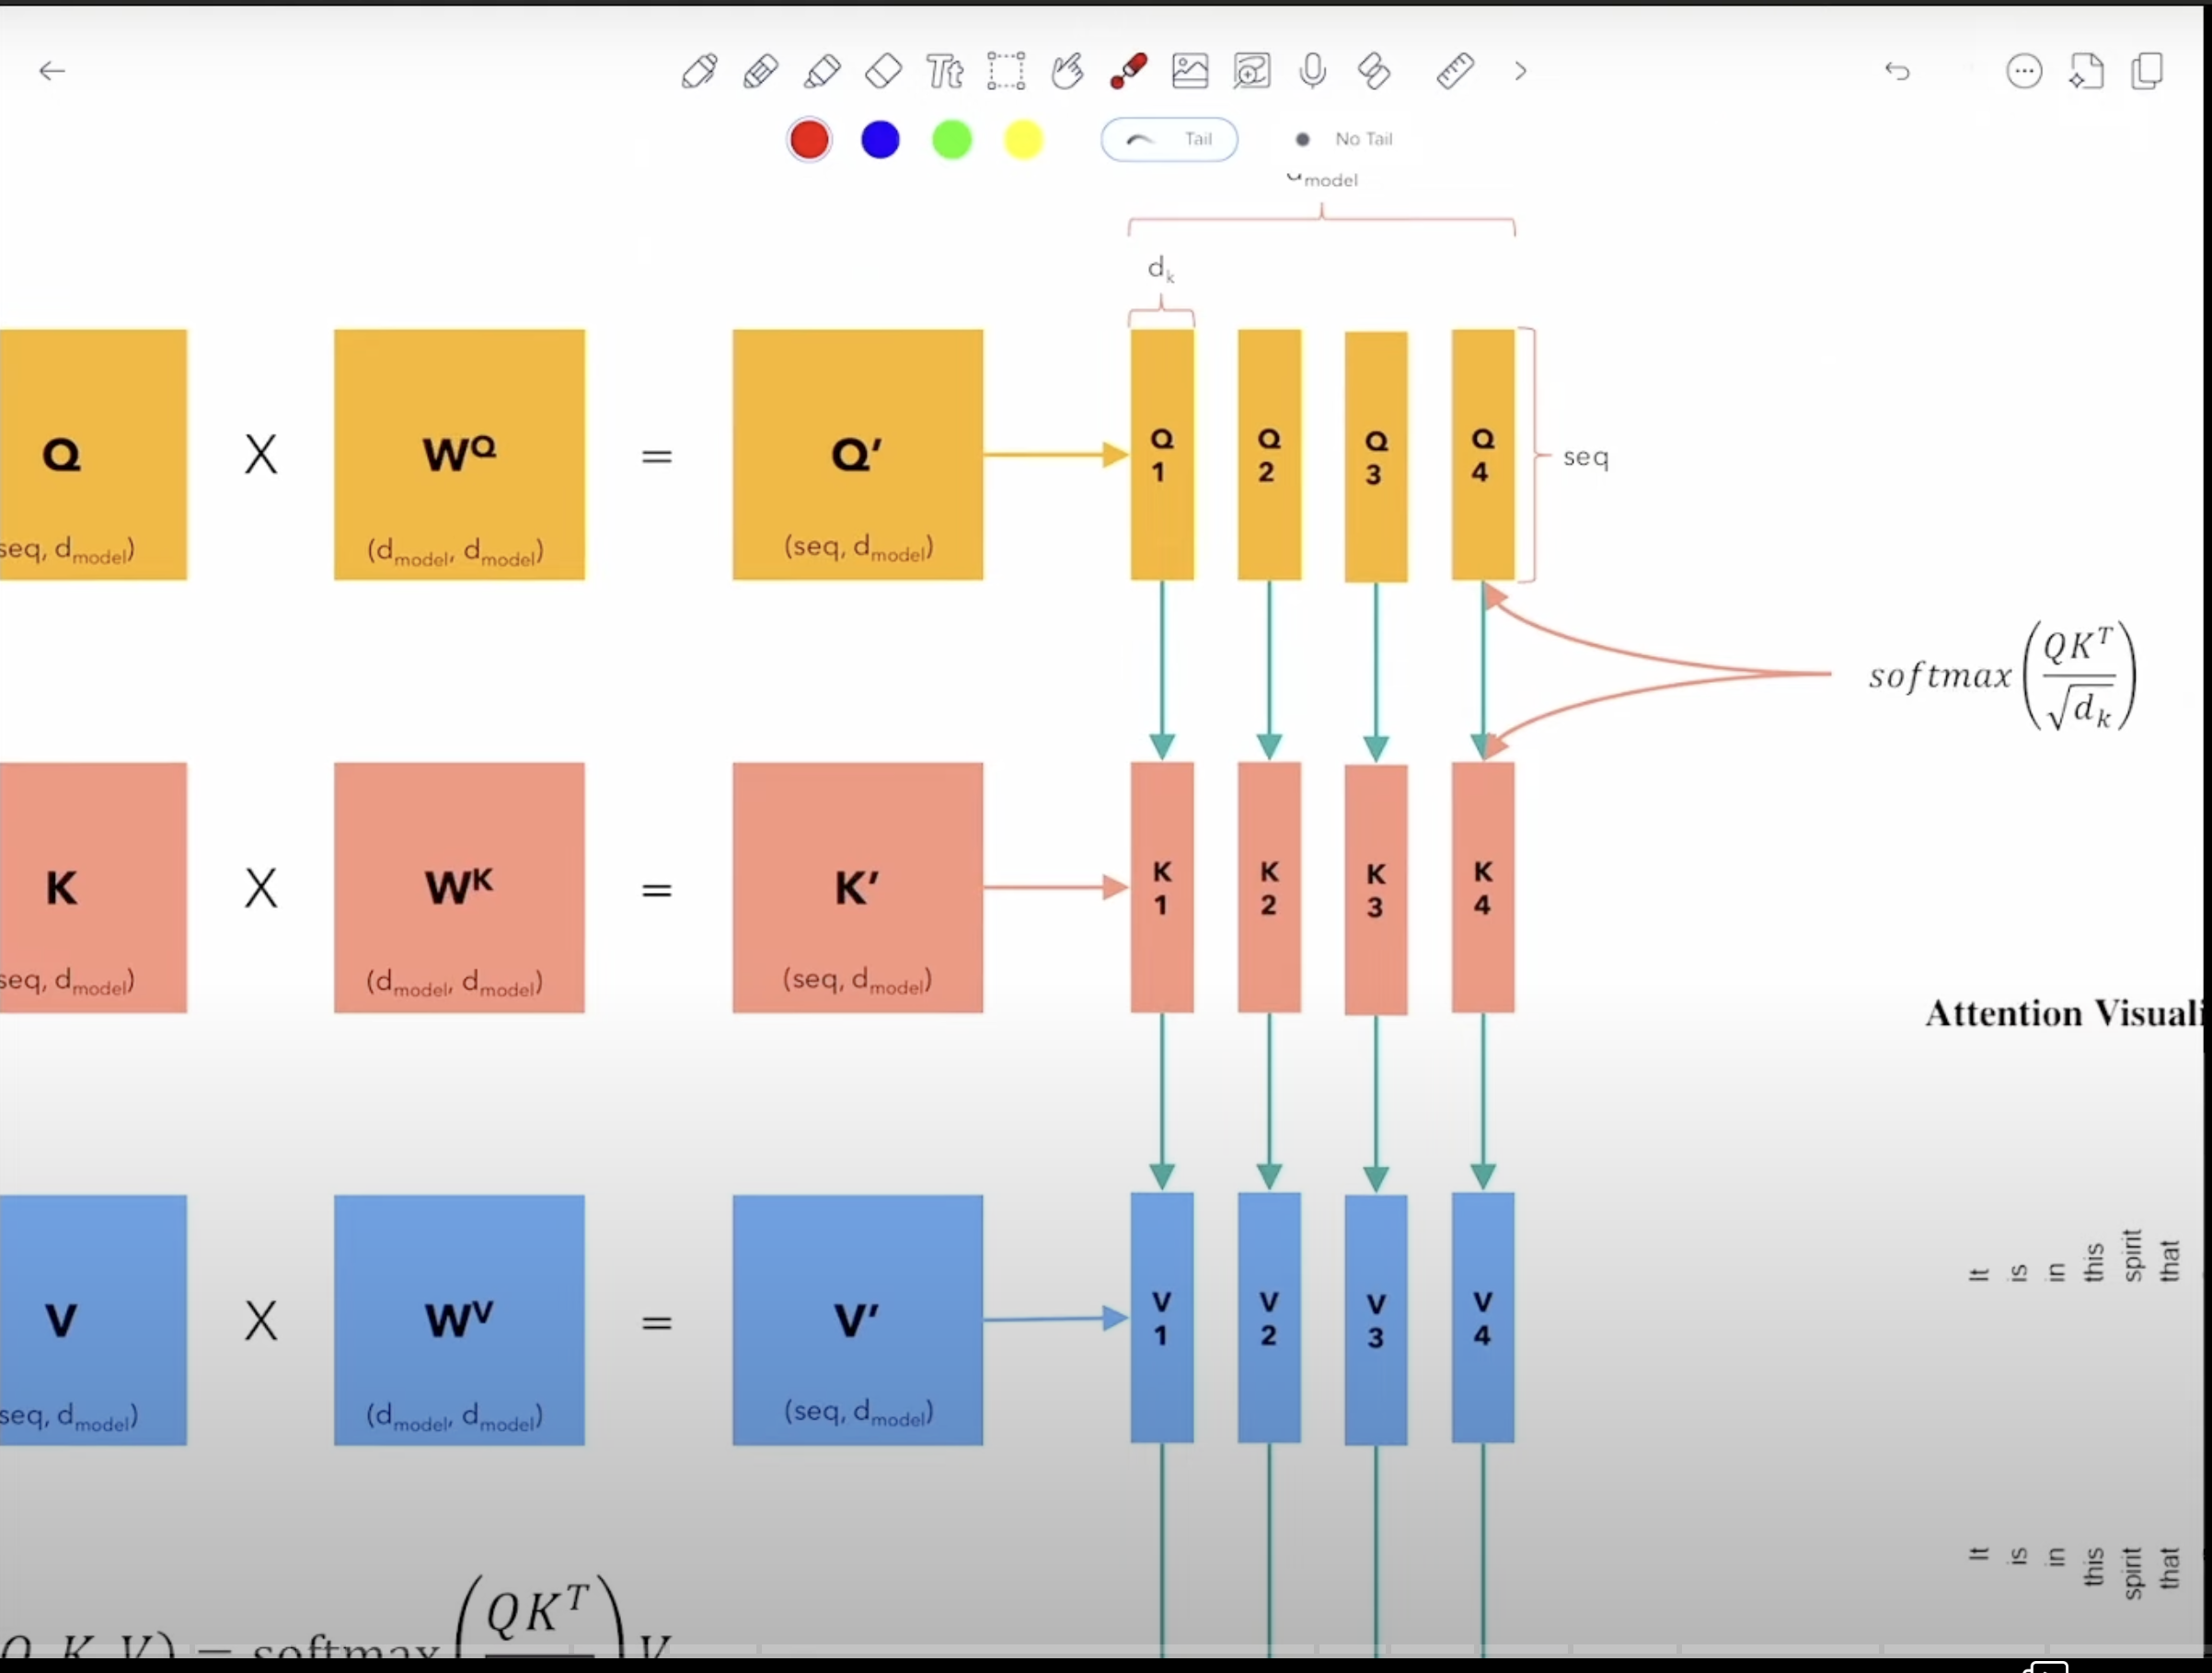